In [1]:
import warnings
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm
from pathlib import Path
from torchvision.datasets import ImageFolder
import wandb
import argparse

In [9]:

parser = argparse.ArgumentParser(description='Description of your program')
parser.add_argument('-pn','--project_name',default='FL_paper', required=True)
parser.add_argument('-rn','--run_name', default='local_training_4_classes', required=True)
parser.add_argument('-d','--data_path', default = '/Users/krystianzielinski/Documents/repos/federated_learning_demo/data/baza_student_raw/ddsm_four_classes_split/', required=True)
parser.add_argument('-c','--n_classes',default=4, required=True)

_StoreAction(option_strings=['-c', '--n_classes'], dest='n_classes', nargs=None, const=None, default=4, type=None, choices=None, required=True, help=None, metavar=None)

In [10]:
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

usage: ipykernel_launcher.py [-h] -pn PROJECT_NAME -rn RUN_NAME -d DATA_PATH
                             -c N_CLASSES
ipykernel_launcher.py: error: the following arguments are required: -pn/--project_name, -rn/--run_name, -d/--data_path, -c/--n_classes


SystemExit: 2

In [ ]:

wandb.init(project=args.project_name)
wandb.run.name=args.run_name
# #############################################################################
# 1. Regular PyTorch pipeline: nn.Module, train, test, and DataLoader
# #############################################################################



In [13]:
warnings.filterwarnings("ignore", category=UserWarning)
DEVICE = torch.device("mps")


model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.classifier = nn.Sequential(nn.Linear(in_features = 1000,out_features = 500),
                                 nn.ReLU(inplace = True),
                                 nn.Linear(in_features = 500,out_features = 4))

ct = 0
for child in model.children():
    ct += 1
    if ct < 9:
        for param in child.parameters():
            param.requires_grad = False

#from scratch
#for param in model.parameters():
#    param.requires_grad = True


Using cache found in /Users/krystianzielinski/.cache/torch/hub/pytorch_vision_v0.10.0


In [37]:

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /Users/krystianzielinski/.cache/torch/hub/pytorch_vision_v0.10.0


In [38]:
ct = 0
for child in model.children():
    ct += 1

In [39]:
ct

10

In [17]:

def load_data():
    norm = [0.5, 0.5, 0.5]
    train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(norm, norm)])

    test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(norm, norm)])

    train_data = ImageFolder('/Users/krystianzielinski/Documents/repos/federated_learning_demo/data/baza_student_raw/ddsm_four_classes_split'+"/train", transform=train_transform)
    valid_data = ImageFolder('/Users/krystianzielinski/Documents/repos/federated_learning_demo/data/baza_student_raw/ddsm_four_classes_split'+"/valid", transform=test_transform)

    return DataLoader(train_data, batch_size=4, shuffle=True), DataLoader(valid_data)


In [32]:

def train(net, trainloader, epochs):
    """Train the model on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for _ in range(epochs):
        for images, labels in tqdm(trainloader):
            optimizer.zero_grad()
            criterion(net(images.to(DEVICE)), labels.to(DEVICE)).backward()
            optimizer.step()


def test(net, testloader):
    """Validate the model on the test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            outputs = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    return loss / len(testloader.dataset), correct / total



net = model.to(DEVICE)
trainloader, testloader = load_data()




In [33]:
class local_training:
    def __init__(self,net):
        self.net = net

    def fit_eval(self, epochs = 10):
        for _ in range(epochs):
            train(self.net, trainloader, epochs=1)
            loss, accuracy = test(self.net,testloader)
            wandb.log({'loss':loss, 'acc':accuracy})
            print("loss:" + str(loss)+" acc: "+str(accuracy))
    def save_model(self, path):
        torch.save(self.net.state_dict(), f'{path}.h5')

In [34]:
lt = local_training(net=net)

In [35]:
lt.net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
lt.fit_eval(epochs = 10)

100%|██████████| 2062/2062 [00:41<00:00, 49.62it/s]


loss:1.4572906329953244 acc: 0.2909796314258002


100%|██████████| 2062/2062 [00:38<00:00, 53.05it/s]

loss:1.8796888804560026 acc: 0.3821532492725509


In [36]:
model.children()

<generator object Module.children at 0x2dd3a0f20>

# WSB

In [2]:
import os

In [3]:
import xml.etree.ElementTree as ET

In [4]:
import pandas as pd

In [5]:
os.chdir('/Users/krystianzielinski/Documents/wsb/data')

In [6]:
DEVICE = torch.device("mps")

In [7]:
images_path = Path('./road_signs/images')
anno_path = Path('./road_signs/annotations')

In [46]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [47]:
df_train = generate_train_df(anno_path)

In [48]:
#label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [50]:
df_train.to_csv('annotations.csv')

In [38]:
df_train = pd.read_csv('annotations.csv', index_col=0)

In [39]:
df_train[]

,filename,width,height,class,xmin,ymin,xmax,ymax
0,road_signs/images/road712.png,300,400,0,98,140,139,182
1,road_signs/images/road706.png,300,400,0,136,92,177,135
2,road_signs/images/road289.png,300,400,1,61,140,146,227
3,road_signs/images/road538.png,300,400,0,115,169,149,205
4,road_signs/images/road510.png,300,400,0,89,201,133,245
...,...,...,...,...,...,...,...,...
872,road_signs/images/road535.png,300,400,0,100,254,180,334
873,road_signs/images/road284.png,300,400,0,111,133,165,187
874,road_signs/images/road290.png,300,400,0,105,157,171,224
875,road_signs/images/road723.png,300,400,0,115,185,160,230


In [114]:
df_train = df_train.loc[(df_train.width == 300)&(df_train.height==400)]

# Train

In [40]:
from torch.utils.data import Dataset, DataLoader

In [41]:
import cv2
import numpy as np

In [42]:
from skimage import io

In [43]:
from PIL import Image

In [44]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transform=None):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        # x = cv2.imread(str(path)).astype(np.float32)
        # x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        # x = io.imread(str(path))
        x = Image.open(str(path)).convert('RGB')
        y_bb = self.bb[idx]
        if self.transform:
            x = self.transform(x)
        return x, y_class, y_bb

In [103]:
norm = np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]])
transform = transforms.Compose([
    transforms.Resize((400, 300)),
    transforms.ToTensor(),
    transforms.Normalize(norm[0],norm[1])
    ])

In [104]:
train_ds = RoadDataset(df_train['filename'],df_train[['xmin', 'ymin', 'xmax', 'ymax']] ,df_train['class'], transform=transform)

In [47]:
train_ds.__getitem__(1)

(tensor([[[ 0.4745,  0.4745,  0.4745,  ...,  0.4431,  0.4275,  0.4196],
          [ 0.4745,  0.4824,  0.4824,  ...,  0.4510,  0.4588,  0.4588],
          [ 0.4667,  0.4745,  0.4824,  ...,  0.4039,  0.4510,  0.4510],
          ...,
          [-0.0588, -0.0588, -0.0588,  ..., -0.1765, -0.1843, -0.1765],
          [-0.0588, -0.0431, -0.0353,  ..., -0.1608, -0.1843, -0.1843],
          [-0.0353, -0.0353, -0.0353,  ..., -0.1765, -0.2000, -0.1608]],
 
         [[ 0.6314,  0.6235,  0.6157,  ...,  0.6392,  0.6157,  0.6078],
          [ 0.6314,  0.6314,  0.6235,  ...,  0.6471,  0.6549,  0.6549],
          [ 0.6157,  0.6235,  0.6235,  ...,  0.5843,  0.6392,  0.6314],
          ...,
          [ 0.0510,  0.0431,  0.0510,  ..., -0.0745, -0.0745, -0.0745],
          [ 0.0667,  0.0745,  0.0824,  ..., -0.0588, -0.0745, -0.0745],
          [ 0.0980,  0.0980,  0.0902,  ..., -0.0588, -0.0745, -0.0431]],
 
         [[ 0.4745,  0.4745,  0.4745,  ...,  0.5294,  0.5059,  0.4980],
          [ 0.4745,  0.4824,

In [48]:
batch_size = 12
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(train_ds, batch_size=1, shuffle=False)

In [49]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [50]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [51]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.to(DEVICE).float()
        y_class = y_class.to(DEVICE)
        y_bb = y_bb.to(DEVICE).float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [52]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.to(DEVICE).float()
            y_class = y_class.to(DEVICE)
            y_bb = y_bb.to(DEVICE).float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, val_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [53]:
import torch.optim as optim

In [54]:
def train(model, trainloader, epochs, C = 1000):
    """Train the model on the training set."""
    model.train()
    total = 0
    sum_loss = 0
    criterion_class = torch.nn.CrossEntropyLoss()
    criterion_bbox = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    for _ in range(epochs):
        for x, y_class, y_bb in tqdm(trainloader):
            out_class, out_bb = model(x.to(DEVICE))
            loss_class = criterion_class(out_class, y_class.to(DEVICE))
            loss_bbox = criterion_bbox(out_bb, y_bb.to(DEVICE))
            loss = loss_class + loss_bbox/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += y_class.shape[0]
            sum_loss += loss.item()
    train_loss = sum_loss/total
    val_loss, val_acc = val_metrics(model, val_dl, C)
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

In [55]:
model = BB_model().to(DEVICE)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

Using cache found in /Users/krystianzielinski/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/homebrew/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
# train(model, train_dl, 10)

In [57]:
train_epocs(model, optimizer, train_dl, val_dl, epochs=15)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1673424517901/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


train_loss 1.634 val_loss inf val_acc 0.462
train_loss 1.269 val_loss 2.158 val_acc 0.566
train_loss 1.077 val_loss 0.984 val_acc 0.716
train_loss 1.038 val_loss 1.361 val_acc 0.661
train_loss 1.016 val_loss 4.527 val_acc 0.445
train_loss 0.961 val_loss 0.921 val_acc 0.765
train_loss 0.943 val_loss 1.374 val_acc 0.700
train_loss 0.982 val_loss 1.046 val_acc 0.767
train_loss 1.020 val_loss 1.143 val_acc 0.712
train_loss 0.983 val_loss 1.589 val_acc 0.749
train_loss 0.957 val_loss 0.889 val_acc 0.764
train_loss 0.916 val_loss 0.994 val_acc 0.759
train_loss 0.929 val_loss 0.943 val_acc 0.769
train_loss 0.914 val_loss inf val_acc 0.672
train_loss 0.899 val_loss 2.368 val_acc 0.554


0.8985857417129465

In [58]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, val_dl, epochs=10)

train_loss 0.915 val_loss 0.877 val_acc 0.779
train_loss 0.831 val_loss 1.080 val_acc 0.756
train_loss 0.854 val_loss 0.849 val_acc 0.775
train_loss 0.854 val_loss 0.982 val_acc 0.767
train_loss 0.830 val_loss 0.848 val_acc 0.777
train_loss 0.825 val_loss 0.866 val_acc 0.779
train_loss 0.815 val_loss 0.898 val_acc 0.771
train_loss 0.819 val_loss 0.873 val_acc 0.772
train_loss 0.826 val_loss 0.868 val_acc 0.784
train_loss 0.809 val_loss 0.846 val_acc 0.783


0.8093331211513097

In [ ]:
import matplotlib.pyplot as plt

In [105]:
dataiter = iter(val_dl)

In [106]:
img, img_class, bbox = dataiter.__next__()

In [108]:
bbox = np.asarray(bbox.cpu().detach()).squeeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


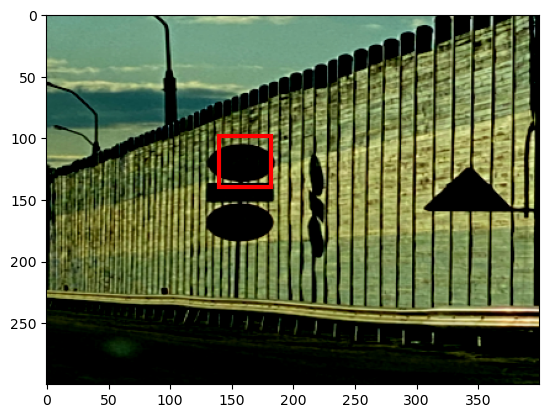

In [109]:
plt.imshow(np.squeeze(img).permute(1, 2, 0))
plt.gca().add_patch(plt.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], color='red',
                         fill=False, lw=3))

In [94]:
img_class, bbox

(tensor([0]), tensor([[ 89, 201, 133, 245]]))

In [95]:
out_class, out_bb = model(img.to(DEVICE))
out_class, out_bb

(tensor([[ 2.8048, -0.5445, -0.6335, -2.1372]], device='mps:0',
        grad_fn=<LinearBackward0>),
 tensor([[115.7002, 166.1620, 160.6989, 209.2535]], device='mps:0',
        grad_fn=<LinearBackward0>))

In [97]:
out_bb = np.asarray(out_bb.cpu().detach()).squeeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


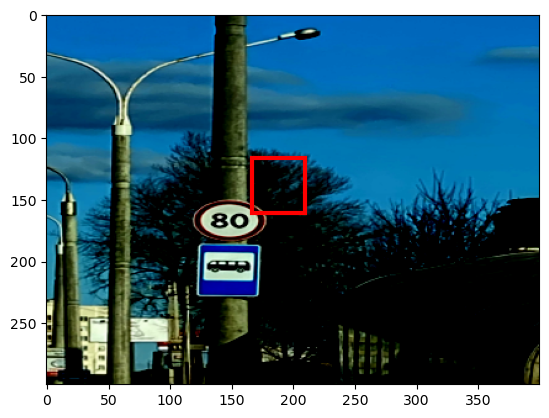

In [98]:
plt.imshow(np.squeeze(img).permute(1, 2, 0))
plt.gca().add_patch(plt.Rectangle((out_bb[1], out_bb[0]), out_bb[3]-out_bb[1], out_bb[2]-out_bb[0], color='red',
                         fill=False, lw=3))